# Machine Learning -- Assignment 3

In [85]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(0)

In [86]:
COL0 = "#E8963C"; COL1 = "#5B7FD4"
BG0  = "#FDF0DC"; BG1  = "#DCE4F7"
BDRY_OPT = "#B044D8"; BDRY_KNN = "black"

In [87]:
N = 150

def sample_class(n, centers, sigma=0.50):
    pts = []
    for _ in range(n):
        c = centers[np.random.randint(len(centers))]
        pts.append(np.random.multivariate_normal(c, np.eye(2)*sigma**2))
    return np.array(pts)

centers0 = np.array([[ 0.0,  2.0], [ -1.0, 0.0], [-2.0, -2.5]])
centers1 = np.array([[ 1.0,  0.5], [ -0.5,  -1.5], [-0.5, 1.5]])

X0 = sample_class(N, centers0, sigma=0.27)
X1 = sample_class(N, centers1, sigma=0.63)
X  = np.vstack([X0, X1])
y  = np.array([0]*N + [1]*N)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [88]:
h = 0.06; pad = 0.7
x1mn,x1mx = X[:,0].min()-pad, X[:,0].max()+pad
x2mn,x2mx = X[:,1].min()-pad, X[:,1].max()+pad
xx, yy = np.meshgrid(np.arange(x1mn,x1mx,h), np.arange(x2mn,x2mx,h))
grid = np.c_[xx.ravel(), yy.ravel()]

clf_bayes = KNeighborsClassifier(n_neighbors=80).fit(X_train, y_train)
Z_bayes   = clf_bayes.predict(grid).reshape(xx.shape)

In [89]:
K_list = [1,2,3,4,5,6,7,8,9,10,12,15,17,20,25,30,40,50,60,75,100]
train_err, test_err = [], []
for k in K_list:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, clf.predict(X_train)))
    test_err.append( 1 - accuracy_score(y_test,  clf.predict(X_test)))

best_idx = int(np.argmin(test_err)); best_k = K_list[best_idx]
k_over   = 1
k_under  = 100   
print(f"Best K={best_k}  train_err={train_err[best_idx]:.3f}  test_err={test_err[best_idx]:.3f}")

cmap_bg = ListedColormap([BG0, BG1])

def make_Z(k):
    return KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)\
                                              .predict(grid).reshape(xx.shape)
Z_best  = make_Z(best_k)
Z_over  = make_Z(k_over)
Z_under = make_Z(k_under)

Best K=2  train_err=0.071  test_err=0.067


In [90]:
def scat(ax, Xp, yp, sz=45, lw=1.3):
    for cls, col in [(0,COL0),(1,COL1)]:
        m = yp==cls
        ax.scatter(Xp[m,0],Xp[m,1],facecolors='none',
                   edgecolors=col,s=sz,linewidths=lw,zorder=5)

def fmt_ax(ax, title=""):
    ax.set_xlabel("$X_1$",fontsize=12); ax.set_ylabel("$X_2$",fontsize=12)
    if title: ax.set_title(title,fontsize=12,fontweight='bold')
    ax.set_xlim(x1mn,x1mx); ax.set_ylim(x2mn,x2mx); ax.tick_params(labelsize=9)

def acc_box(ax, k):
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    tr  = accuracy_score(y_train, clf.predict(X_train))
    te  = accuracy_score(y_test,  clf.predict(X_test))
    ax.text(0.02,0.98,f'Train acc: {tr:.1%}  |  Test acc: {te:.1%}',
            transform=ax.transAxes,fontsize=8.5,va='top',
            bbox=dict(facecolor='white',alpha=0.8,edgecolor='gray',pad=3))

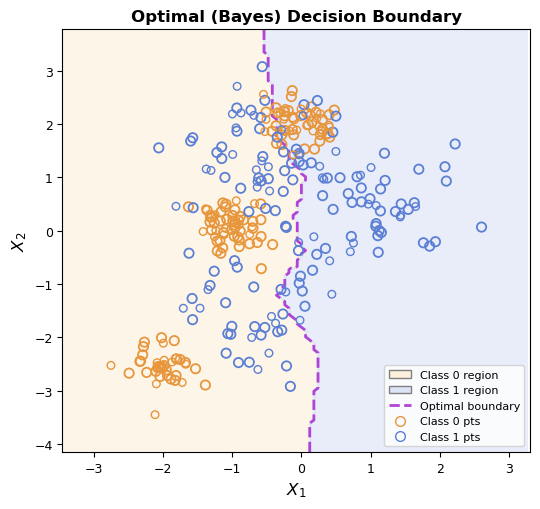

In [91]:
plt.close('all')
fig,ax = plt.subplots(figsize=(5.5,5.2))
ax.contourf(xx,yy,Z_bayes,cmap=cmap_bg,alpha=0.65)
ax.contour(xx,yy,Z_bayes,levels=[0.5],colors=[BDRY_OPT],linewidths=2,linestyles='--')
scat(ax,X_train,y_train); scat(ax,X_test,y_test,sz=30,lw=1.0)
fmt_ax(ax,"Optimal (Bayes) Decision Boundary")
handles=[
    mpatches.Patch(facecolor=BG0,edgecolor='gray',label='Class 0 region'),
    mpatches.Patch(facecolor=BG1,edgecolor='gray',label='Class 1 region'),
    plt.Line2D([],[],color=BDRY_OPT,ls='--',lw=2,label='Optimal boundary'),
    plt.Line2D([],[],marker='o',ls='none',mfc='none',mec=COL0,ms=7,label='Class 0 pts'),
    plt.Line2D([],[],marker='o',ls='none',mfc='none',mec=COL1,ms=7,label='Class 1 pts'),
]
ax.legend(handles=handles,fontsize=8,loc='lower right')
plt.tight_layout()
fig

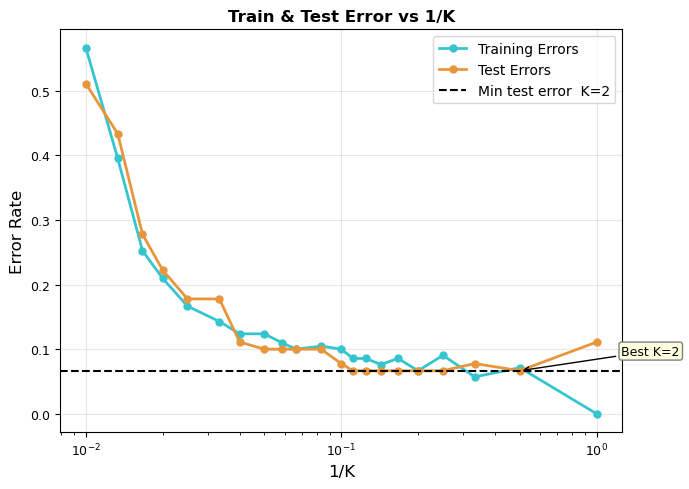

In [92]:
plt.close('all')
fig,ax = plt.subplots(figsize=(7,5))
inv_K = [1/k for k in K_list]
ax.plot(inv_K,train_err,'o-',color='#36C5CE',lw=2,ms=5,label='Training Errors')
ax.plot(inv_K,test_err, 'o-',color='#E8963C',lw=2,ms=5,label='Test Errors')
ax.axhline(test_err[best_idx],color='black',ls='--',lw=1.5,
           label=f'Min test error  K={best_k}')
ax.set_xscale('log')
ax.set_xlabel("1/K",fontsize=12)
ax.set_ylabel("Error Rate",fontsize=12)
ax.set_title("Train & Test Error vs 1/K",fontsize=12,fontweight='bold')
ax.legend(fontsize=10); ax.grid(True,alpha=0.3); ax.tick_params(labelsize=9)
ax.annotate(f'Best K={best_k}',
            xy=(1/best_k,test_err[best_idx]),
            xytext=(1/best_k*2.5,test_err[best_idx]+0.025),
            arrowprops=dict(arrowstyle='->',color='black'),fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2',facecolor='lightyellow',edgecolor='gray'))
plt.tight_layout()
fig

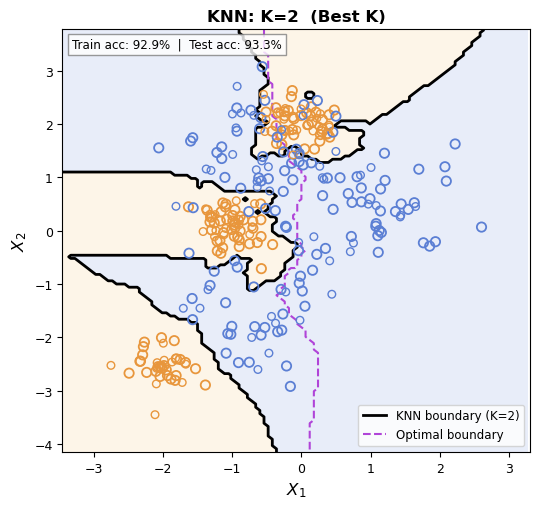

In [93]:
plt.close('all')
fig,ax = plt.subplots(figsize=(5.5,5.2))
ax.contourf(xx,yy,Z_best,cmap=cmap_bg,alpha=0.65)
ax.contour(xx,yy,Z_best, levels=[0.5],colors=[BDRY_KNN],linewidths=2)
ax.contour(xx,yy,Z_bayes,levels=[0.5],colors=[BDRY_OPT],linewidths=1.5,linestyles='--')
scat(ax,X_train,y_train); scat(ax,X_test,y_test,sz=30,lw=1.0)
fmt_ax(ax,f"KNN: K={best_k}  (Best K)")
acc_box(ax,best_k)
ax.legend(handles=[
    plt.Line2D([],[],color=BDRY_KNN,lw=2,label=f'KNN boundary (K={best_k})'),
    plt.Line2D([],[],color=BDRY_OPT,ls='--',lw=1.5,label='Optimal boundary'),
],fontsize=8.5,loc='lower right')
plt.tight_layout()
fig

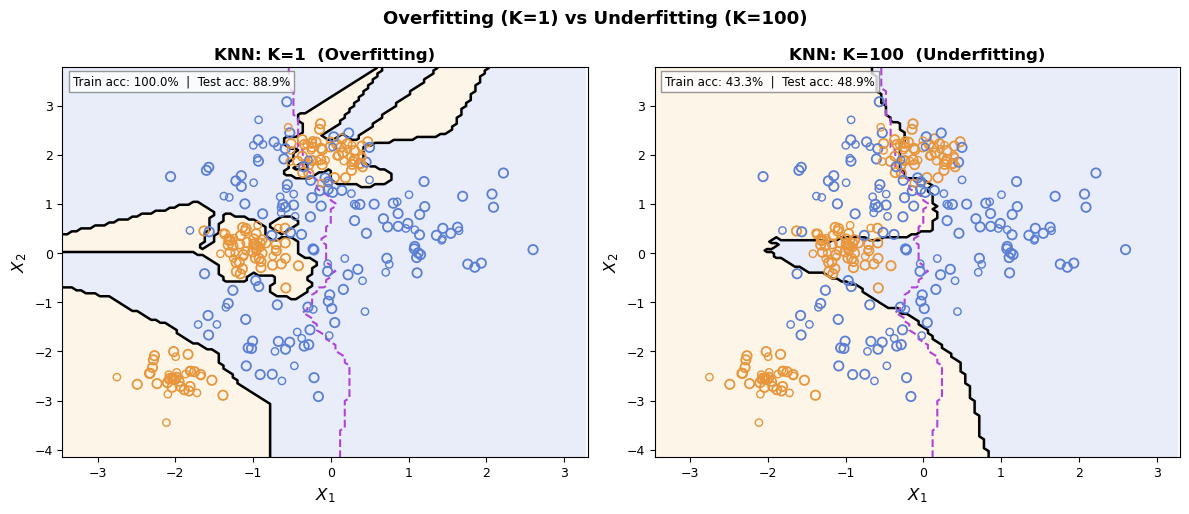

In [94]:
plt.close('all')
fig,(axL,axR) = plt.subplots(1,2,figsize=(12,5.2))
for ax,Z,k,lbl in [
    (axL,Z_over,  k_over,  f"KNN: K={k_over}  (Overfitting)"),
    (axR,Z_under, k_under, f"KNN: K={k_under}  (Underfitting)"),
]:
    ax.contourf(xx,yy,Z,cmap=cmap_bg,alpha=0.65)
    ax.contour(xx,yy,Z, levels=[0.5],colors=[BDRY_KNN],linewidths=1.8)
    ax.contour(xx,yy,Z_bayes,levels=[0.5],
               colors=[BDRY_OPT],linewidths=1.5,linestyles='--')
    scat(ax,X_train,y_train); scat(ax,X_test,y_test,sz=28,lw=1.0)
    fmt_ax(ax,lbl); acc_box(ax,k)
fig.suptitle("Overfitting (K=1) vs Underfitting (K=100)",
             fontsize=13,fontweight='bold')
plt.tight_layout()
fig

# Summary

We were asked to recreate the graphs from slides 27-30 using our own Guassian distribution samples. For my experiments, I decided to use real numbers from -2.5 to 1.5 for my arrays of center0 and center1. After that, I decided to set the sigma for x0 to 0.27 and and the sigma for x1 to 0.63. Thus, creating the uniqueness for the Bayes boundary, underfitting, overfitting, and test graphs. Understanding that when we change these values, we can create all sorts of different types of Guassian distributions (some look very weird I will say). With the values that I chose, the best K value that I recieve is when K = 2. So, when K = 2, we know that's the most optimal graph that we can get with test accuracy = 93.3% and training accuracy = 92.9% ( with the test and training error being 0.067 and 0.071). When K = 100, we clearly shouldn't use that graph as the test accuaracy and training accuaracy are both below 50%. Lastly, when K = 1, we should not use this as the training accuaracy is 100% but the test accuaracy is 88.9% (lower than when K = 2). 